The purpose of this notebook is to show how bootstrapping can be used to estimate uncertainties in model parameters. Data related to the intensity of a radioactive isotope as a function of time is imported, and a linear weighted least squares fit is applied to Ln(Intensity) vs Ln(Time). The fit parameters (gradient and intercept) are stored. Bootstrapping is then performed to repeatedly resample the dataset, perform a weighted least squares fit and store the corresponding fit parameters for each iteration in a list. The mean of these resampled parameters is calculated and the standard deviation is used as the measure of uncertainty if the sampling distributions are Gaussian, otherwise the median and 16 - 84% confidence interval is used.

As the gradient and intercept represent the decay constant and initial activity, these bootstrapped parameters are used to fit an exponential function to the original data. The Chi squared statistic is calculated to provide a measure of goodness of fit and the half life is calculated from the decay constant to identify the isotope from a list of candidates.

In [ ]:
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import scipy

#READING IN DATA
file_path = 
data = np.loadtxt(file_path, dtype = float)

x_data = data[:, 0]
time_interval = x_data[1] - x_data[0]

y1_raw = data[:, 1]/time_interval
y1_data = np.log(y1_raw)
y1_error_raw = data[:, 2]/time_interval
y1_error = y1_error_raw/y1_raw

Importing data

In [2]:
#CONSTANTS
#Isotope Half Lives (s)
Cs_120 = 61.2
Cs_121 = 154.8
Cs_124 = 30.9
Ba_123 = 162
Ba_124 = 660
Ba_125 = 210
Ba_137 = 153.1
Eu_137 = 8.4
Eu_138 = 12.1
Eu_139 = 17.9
Eu_143 = 155.4
W_166 = 19.2
W_168 = 51
W_169 = 76.2
Np_229 = 240
Np_230 = 276
Np_232 = 882

Some candidate isotopes from which the unknown isotope will be identified

In [3]:
#FUNCTIONS

#Input data, gradient and intercept to return linear fit
def linear(x, m, c):
    return m*x + c

#Input data, initial activity and decay constant to return exponential fit
def exp1(x, A1, lambda1):
    return A1*np.exp(-lambda1*x)

#Input x, y data and errors to return sums used in least squares fit
def chi_sums(x_data, y_data, error):
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    error = np.array(error)
    
    inv_y_error2 = 1/(error*error)
    S = np.sum(inv_y_error2)
    x = x_data * inv_y_error2
    y = y_data * inv_y_error2
    xy = x_data * y_data * inv_y_error2
    xx = x_data * x_data * inv_y_error2
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(xy)
    sum_xx = np.sum(xx)
    
    return S, sum_x, sum_y, sum_xx, sum_xy

#Function to input sums from chi_sums to return gradient for least squares fit
def grad(S, sum_x, sum_y, sum_xx, sum_xy):
    gradient = (S*sum_xy - sum_x*sum_y)/(S*sum_xx - sum_x*sum_x)
    return gradient

#Function to input sums from chi_sums to return intercept for least squares fit
def intercept(S, sum_x, sum_y, sum_xx, sum_xy):
    intercept = (sum_xx*sum_y - sum_x*sum_xy)/(S*sum_xx - sum_x*sum_x)
    return intercept

#Function to input data, fit and errors to return chi squared value
def chi2(data, fit, error):
    x = ((data-fit)**2)/error**2
    chi = np.sum(x)
    return chi

#Function to input x data, y data, errors, an initial fit, residual and interations to bootstrap gradients and intercepts
#Mean + standard deviations and Median + 16 - 84% CI of gradients and intercepts are returned
def bootstrap(x_data, y_data, error, initial_fit, initial_resids, iterations):
    
    m_new_list = []
    c_new_list = []
    
    for i in np.arange(1, iterations, 1):
        indices = random.sample(range(0, len(x_data)), k = len(x_data)) #Random numbers selected from list of consecutive numbers ranging from 0 to len(x_data)
        res_sample = [initial_resids[a] for a in indices] #Residuals selected from initial residual list at indices within the indices list
        error = [error[a] for a in indices] #Corresponding errors at same indices selected and held in list
        
        new_fit = initial_fit + res_sample #New fit generated from initial fit + new residuals
        
        S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, new_fit, error) #New chi sums calculated
        
        m_new = grad(S, sum_x, sum_y, sum_xx, sum_xy) #Corresponding gradient and intercepts calculated
        c_new = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
        
        m_new_list.append(m_new) #Gradients and Intercepts appended to lists
        c_new_list.append(c_new)
    
    #Various statistics calculated from gradient and intercept lists
    mean_m = statistics.mean(m_new_list)
    median_m = statistics.median(m_new_list)
    std_m = statistics.stdev(m_new_list)

    mean_c = statistics.mean(c_new_list)
    median_c = statistics.median(c_new_list)
    std_c = statistics.stdev(c_new_list)
    
    return mean_m, median_m, std_m, mean_c, median_c, std_c, m_new_list, c_new_list

Functions are defined here to perform linear and exponential fits, and most importantly to bootstrap the dataset. The bootstrap function will return the mean and median parameters with standard deviations as well lists containing all of the individual parameters from each resampled dataset. These lists are mainly used for visualization purposes shown later.

In [4]:
#FUNCTIONS - DATASET PROCESSING - Previous functions are combined with commands to return salient data and help reduce redundancy

#Function to perform chi squared fit on dataset with errors and return gradient, intercept, residuals and chi squared value
#Inputs are the x and y data with errors
def perform_chi_square_fit(x_data, y_data, error):
    S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, y_data, error)
    m = grad(S, sum_x, sum_y, sum_xx, sum_xy)
    c = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
    fit = linear(x_data, m, c)
    residuals = fit - y_data
    return m, c, fit, residuals

#Function to use gradient and intercept parameters from linear Ln Activity vs Ln Time fit and provide an exponential fit with corresponding chi squared value
#y_data is Ln activity used for the linear fit, raw_data is the original data for which the exponential fit is determined
def process_exp_dataset(x_data, y_data, error, raw_data, raw_error):
    m, c, fit = perform_chi_square_fit(x_data, y_data, error)[:3]
    exp_fit = exp1(x_data, np.exp(c), -m)
    exp_res = exp_fit - raw_data
    chi_squared = chi2(raw_data, exp_fit, raw_error)
    return exp_fit, exp_res, chi_squared

#Function to prepare data for plotting a histogram of bootstrapped gradients and intercepts
#Data for a cumulative chart with 16 - 84% CIs is also prepared
def process_bootstrap_histogram(boot_mlist, boot_clist, bins=30):
    values_m, base_m = np.histogram(boot_mlist, bins=bins)
    cumulative_m = np.cumsum(values_m)
    values_c, base_c = np.histogram(boot_clist, bins=bins)
    cumulative_c = np.cumsum(values_c)
    
    x_percentile_16_m = np.percentile(base_m[:-1], 16)
    x_percentile_84_m = np.percentile(base_m[:-1], 84)
    x_percentile_16_c = np.percentile(base_c[:-1], 16)
    x_percentile_84_c = np.percentile(base_c[:-1], 84)
    
    confidence_interval_m = (x_percentile_16_m, x_percentile_84_m)
    confidence_interval_c = (x_percentile_16_c, x_percentile_84_c)
    
    med_unc_m = np.ones(2) * np.median(boot_mlist) - confidence_interval_m
    med_unc_c = np.ones(2) * np.median(boot_clist) - confidence_interval_c
    
    return values_m, base_m, cumulative_m, values_c, base_c, cumulative_c, confidence_interval_m, confidence_interval_c, med_unc_m, med_unc_c

#Function to calculated half lives from decay constants with uncertainties propagated
#Half lives can be calculated from both mean and median decay constants 
def calculate_half_life(mean_m, std_m, med_m, med_unc_m):
    t_half = np.log(2) / -mean_m
    t_unc = (np.log(2) / mean_m**2) * std_m
    t_half_med = np.log(2) / -med_m
    t_med_unc = (np.log(2) / med_m**2) * med_unc_m
    return t_half, t_unc, t_half_med, t_med_unc

#Function to calculate the number of particles in the isotope from activity at the detector
#Percentage uncertainties in the cross section, decay constant and activity are used to determine error in particle number
def calculate_number(dist, cross_sec, mean_m, std_m, mean_c, std_c, percent_unc_cs):
    sa = 4 * np.pi * dist ** 2
    area_ratio = sa / cross_sec
    N = (np.exp(mean_c) / -mean_m) * area_ratio
    percent_unc_m = (std_m / -mean_m) * 100
    percent_unc_c = (np.exp(mean_c) * std_c / np.exp(mean_c)) * 100
    total_percent_unc = percent_unc_m + percent_unc_c + percent_unc_cs
    N_unc = (N / 100) * total_percent_unc
    return N, N_unc, percent_unc_m, percent_unc_c, total_percent_unc

#Function to implement scipy to perform data fit for comparison
def scipy_chi2(x_data, y_data, raw_data, raw_error):
    parameters, covariance = scipy.optimize.curve_fit(linear, x_data, y_data)
    m_opt, c_opt = parameters
    exp_fit_scipy = exp1(x_data, np.exp(c_opt), -m_opt)
    chi2_scipy = chi2(raw_data, exp_fit_scipy, raw_error)
    return m_opt, c_opt, exp_fit_scipy, chi2_scipy

Some additional functions are defined here. The main one is process_bootstrap_histogram which is used to return the 16 - 84% confidence interval for the median resampled parameters.

The other important function is scipy_chi2. This is used to provide a fit to the data using the scipy.optimize.curve_fit function from the scipy module. A chi squared statistic is also calculated from this fit for comparison. 

There is also a function to calculate the half life of the isotope with uncertainties, using the mean and standard deviation and median and confidence interval of the bootstrapped decay constant.

In [5]:
#IMPLEMENTING FUNCTIONS FOR DATASETS
# Dataset 1
#Initial fit parameters and residuals determined from least squares fit
m1, c1, fit1, res1 = perform_chi_square_fit(x_data, y1_data, y1_error)

#Fit parameters used for exponential fit
exp_fit1, exp_res1, chi2_1 = process_exp_dataset(x_data, y1_data, y1_error, y1_raw, y1_error_raw)

#Fit parameters are bootstrapped to determine best fit parameters and uncertainties
boot1 = bootstrap(x_data, y1_data, y1_error, fit1, res1, 1000)
mean_m1, med_m1, std_m1, mean_c1, med_c1, std_c1, boot_mlist1, boot_clist1 = boot1

#Information for bootstrapped parameter histograms calculated
values_m1, base_m1, cumulative_m1, values_c1, base_c1, cumulative_c1, confidence_interval_m1, confidence_interval_c1, med_unc_m1, med_unc_c1 = process_bootstrap_histogram(boot_mlist1, boot_clist1)

#Isotope half life calculcated with uncertainties
t_half1, t_unc1, t_half_med1, t_med_unc1 = calculate_half_life(mean_m1, std_m1, med_m1, med_unc_m1)

#Number of particles with uncertainties calculated
N1, N1_unc, percent_unc_m1, percent_unc_c1, total_percent_unc1 = calculate_number(dist[0], cross_sec, mean_m1, std_m1, mean_c1, std_c1, percent_unc_cs)

#Scipy fit paramters calculated
m_opt1, c_opt1, exp_fit_scipy1, chi2_scipy_1 = scipy_chi2(x_data, y1_data, y1_raw, y1_error_raw)

Implementing functions to return fits from bootstrapped parameters and scipy.optimize.curve_fit.

The Isotopes half life is also calculated.

In [6]:
#PRINT STATEMENTS - DECAY CONSTANTS, INITIAL ACTIVITIES
print('DECAY CONSTANTS AND INITIAL ACTIVITIES')
print('Dataset 1: Decay Constant (Mean and St Dev) = ' + str(np.abs(mean_m1)) + ' ' + u"\u00B1" + ' ' + str(std_m1))
print('Dataset 1: Decay Constant (Median and 16-84% CI) = ' + str(np.abs(med_m1)) + ' ' + u"\u00B1" + ' ' + str(np.abs(med_unc_m1)))
print('Dataset 1: Initial Activity (Mean and St Dev) = ' + str(np.exp(mean_c1)) + ' ' + u"\u00B1" + ' ' + str(np.exp(mean_c1)*std_c1))
print('Dataset 1: Initial Activity (Median and 16-84% CI) = ' + str(np.exp(med_c1)) + ' ' + u"\u00B1" + ' ' + str(np.abs(np.exp(med_c1)*med_unc_c1)))
print('Dataset 1: Chi Squared = ' + str(chi2_1))
print('Dataset 1: Scipy Decay Constant  = ' + str(np.abs(m_opt1)))
print('Dataset 1: Scipy Initial Activity  = ' + str(np.exp(c_opt1)))
print('Dataset 1: Chi Squared Scipy Parameters  = ' + str(chi2_scipy_1))

DECAY CONSTANTS AND INITIAL ACTIVITIES
Dataset 1: Decay Constant (Mean and St Dev) = 0.05754804925597865 ± 0.0006388194137437387
Dataset 1: Decay Constant (Median and 16-84% CI) = 0.05755838341279961 ± [0.00143729 0.00156906]
Dataset 1: Initial Activity (Mean and St Dev) = 3074.0732058712665 ± 85.78196993344996
Dataset 1: Initial Activity (Median and 16-84% CI) = 3070.8721505662015 ± [167.08583827 172.07625402]
Dataset 1: Chi Squared = 100.88791203014584
Dataset 1: Scipy Decay Constant  = 0.05823232561361036
Dataset 1: Scipy Initial Activity  = 3085.1182057557953
Dataset 1: Chi Squared Scipy Parameters  = 104.06273947955658


Fit parameters are shown here with corresponding chi squared statistics. It can be seen that the fit obtained from bootstrapping provides a better fit to the data than using scipy.optimize.curve_fit.

In [24]:
#PRINT STATEMENTS - HALF LIVES
print('ISOTOPE HALF LIFE WITH UNCERTAINTY')
print('Dataset 1: Half Life (Mean & St Dev) = ' + str(t_half1) + ' ' + u"\u00B1" + ' ' + str(t_unc1) + 's')
print('Dataset 1: Half Life (Median & CI) = ' + str(t_half_med1) + ' ' + u"\u00B1" + ' ' + str(np.abs(t_med_unc1)))

ISOTOPE HALF LIFE WITH UNCERTAINTY
Dataset 1: Half Life (Mean & St Dev) = 12.044668577326874 ± 0.1337033699453543s
Dataset 1: Half Life (Median & CI) = 12.042506051443514 ± [0.30071423 0.32828258]


In [25]:
#IDENTIFYING ISOTOPE FROM CALCULATED HALF LIFE
print('ISOTOPE IDENTITY FROM CLOSEST MATCH IN CANDIDATE LIST')
half_life_listnames = np.array(['Cesium_120', 'Cesium_121', 'Cesium_124', 'Barium_123', 'Barium_124', 'Barium_125', 'Barium_137', 'Europium_137', 'Europium_138', 'Europium_139', 'Europium_143', 'Tungsten_166', 'Tungsten_168', 'Tungsten_169', 'Neptunium_229', 'Neptunium_230', 'Neptunium_232'])
half_life_list = np.array([Cs_120, Cs_121, Cs_124, Ba_123, Ba_124, Ba_125, Ba_137, Eu_137, Eu_138, Eu_139, Eu_143, W_166, W_168, W_169, Np_229, Np_230, Np_232])

dataset_half_life = t_half1 #change to t_half2, 3 or 4 to identify isotopes from half lives of other datasets

diff_list = []

for i in half_life_list:
    half_life_diff = np.abs(dataset_half_life - i)
    diff_list.append(half_life_diff)

isotope_index = diff_list.index(min(diff_list))
isotope_half_life = half_life_list[isotope_index]
isotope_identity = half_life_listnames[isotope_index]

print('Isotope present in sample = ' + ' ' + isotope_identity)
print('Isotope half life = ' + ' ' + str(isotope_half_life))

ISOTOPE IDENTITY FROM CLOSEST MATCH IN CANDIDATE LIST
Isotope present in sample =  Europium_138
Isotope half life =  12.1


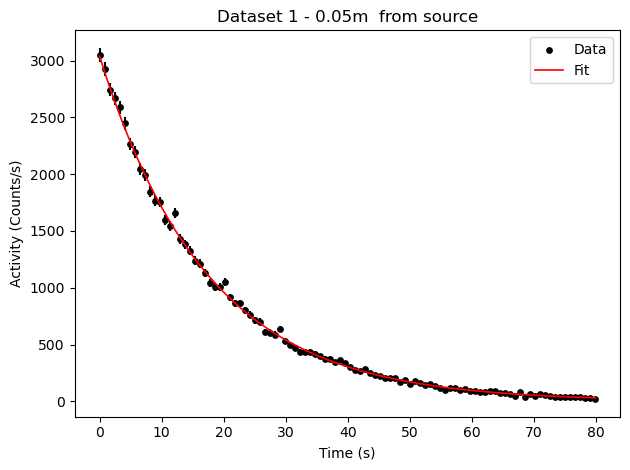

In [15]:
#PLOTS - EXPONENTIAL FITS TO DATA
#Plot for Dataset 1

plt.scatter(x_data, y1_raw, s=15, color='black', label='Data')
plt.errorbar(x_data, y1_raw, y1_error_raw, linestyle='', color='black')
plt.plot(x_data, exp_fit1, color='red', linewidth=1.2, label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Activity (Counts/s)')
plt.title('Dataset 1 - 0.05m  from source')
plt.legend(loc='upper right')

This is the fit obtained using bootstrapping.

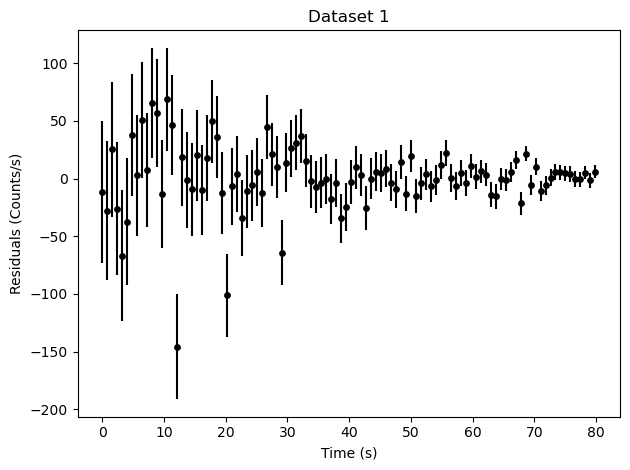

In [16]:
#PLOTS - RESIDUALS

plt.scatter(x_data, exp_res1, s=15, color='black', label='Data')
plt.errorbar(x_data, exp_res1, y1_error_raw, linestyle='', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Residuals (Counts/s)')
plt.title('Dataset 1')

These are the residuals from the fit. Roughly even scattering arond 0 indicates a good fit.

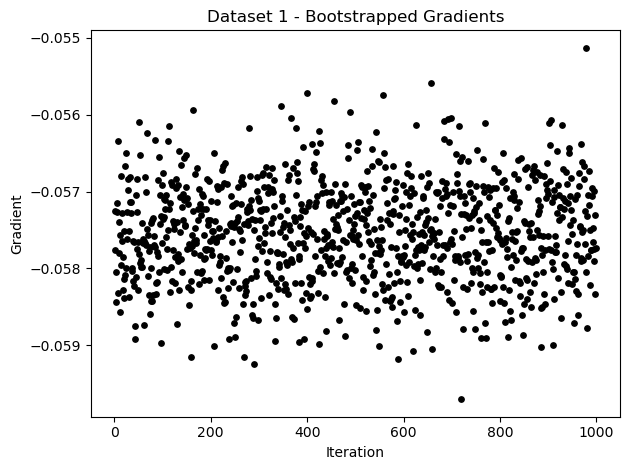

In [18]:
#PLOTS - BOOTSTRAPPED GRADIENTS
points = np.linspace(1, len(boot_mlist1), len(boot_mlist1))
plt.scatter(points, boot_mlist1, s=15, color='black', label='Data')
plt.xlabel('Iteration')
plt.ylabel('Gradient')
plt.title('Dataset 1 - Bootstrapped Gradients')

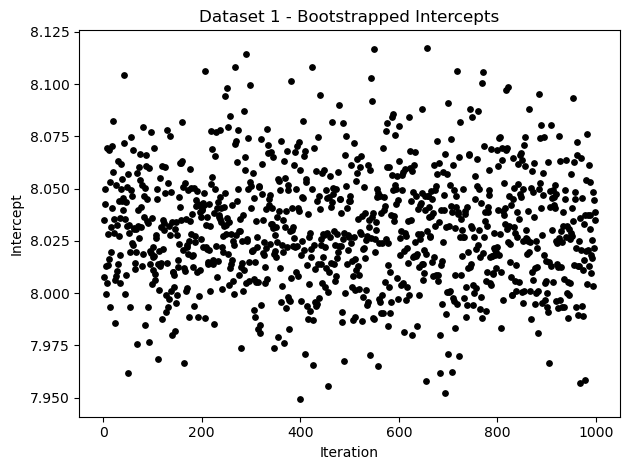

In [19]:
#PLOTS - BOOTSTRAPPED INTERCEPTS

plt.scatter(points, boot_clist1, s=15, color='black', label='Data')
plt.xlabel('Iteration')
plt.ylabel('Intercept')
plt.title('Dataset 1 - Bootstrapped Intercepts')

These are the individual parameters obtained in each resample of the original dataset. Again, the best fit parameter is the mean/median of these individual parameters.

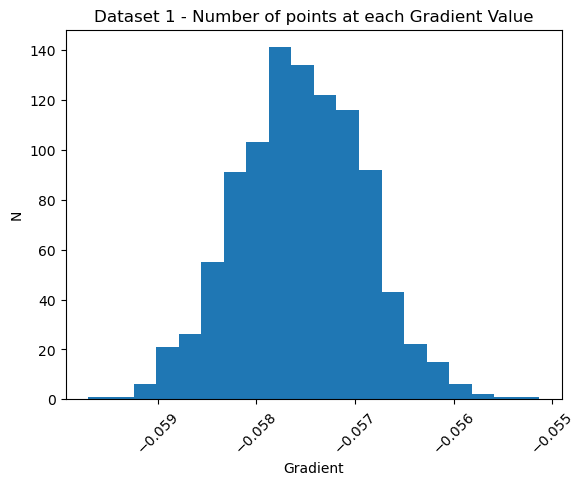

In [20]:
#PLOTS - BOOTSTRAPPED GRADIENT HISTOGRAMS

plt.hist(boot_mlist1, bins = 20)
plt.xlabel('Gradient')
plt.ylabel('N')
plt.title('Dataset 1 - Number of points at each Gradient Value')
plt.tick_params(axis='x', rotation=45)  

Text(0.5, 1.0, 'Dataset 1 - Number of points at each Intercept Value')

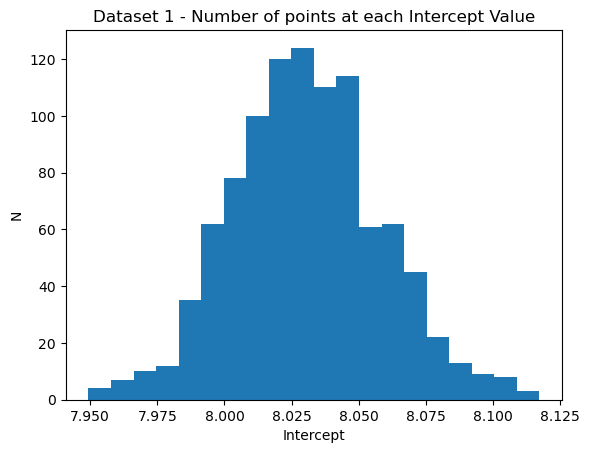

In [21]:
#PLOTS - BOOTSTRAPPED INTERCEPT HISTOGRAMS

plt.hist(boot_clist1, bins = 20)
plt.xlabel('Intercept')
plt.ylabel('N')
plt.title('Dataset 1 - Number of points at each Intercept Value')

These are the resampled parameters displayed as a histograms and they follow a normal distribution. Hence standard deviations can provide good estimates for the uncertainties in these fit parameters.